Algoritmo Genético para Otimização de Carteira de Ações
Simulando preços das ações...


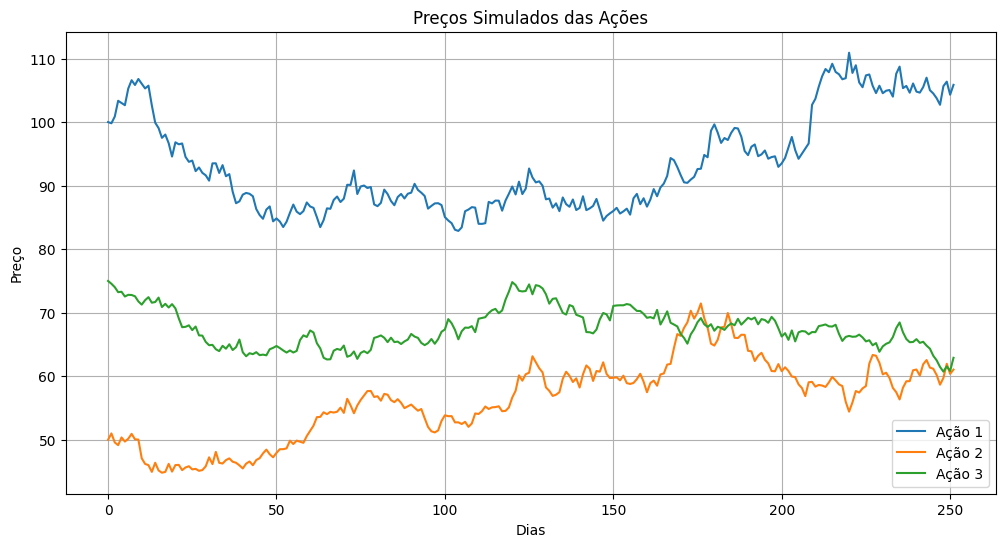


Executando algoritmo genético...
Geração 0: Melhor Fitness = 0.8109
Geração 10: Melhor Fitness = 0.8480
Geração 20: Melhor Fitness = 0.8480
Geração 30: Melhor Fitness = 0.8480
Geração 40: Melhor Fitness = 0.8480

RESULTADOS DA OTIMIZAÇÃO DE CARTEIRA
Melhor Sharpe Ratio: 0.8480
Retorno Total da Carteira: 17.98%
Risco (Volatilidade): 21.20%

Distribuição Otimizada:
Ação 1: 35.66%
Ação 2: 64.34%
Ação 3: 0.00%


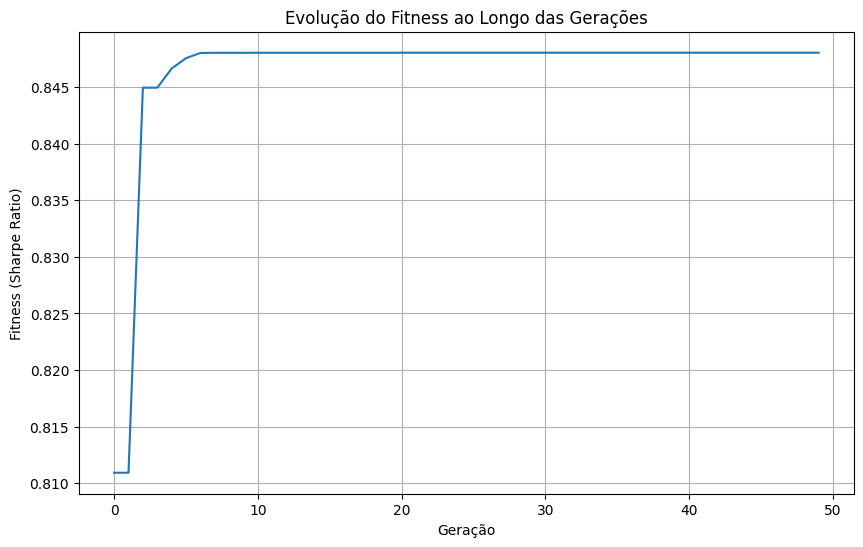


Algoritmo concluído!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import random

class AlgoritmoGeneticoCarteira:
    def __init__(self, num_acoes: int = 3, tamanho_populacao: int = 100,
                 num_geracoes: int = 50, taxa_mutacao: float = 0.1,
                 taxa_crossover: float = 0.8):
        """
        Inicializa o algoritmo genético para otimização de carteira

        Args:
            num_acoes: Número de ações na carteira
            tamanho_populacao: Tamanho da população
            num_geracoes: Número de gerações para evolução
            taxa_mutacao: Taxa de mutação (0-1)
            taxa_crossover: Taxa de crossover (0-1)
        """
        self.num_acoes = num_acoes
        self.tamanho_populacao = tamanho_populacao
        self.num_geracoes = num_geracoes
        self.taxa_mutacao = taxa_mutacao
        self.taxa_crossover = taxa_crossover

        # Simular preços das ações
        self.precos_acoes = self._simular_precos_acoes()

        # Histórico de fitness para plotagem
        self.historico_fitness = []

    def _simular_precos_acoes(self, dias: int = 252) -> np.ndarray:
        """
        Simula preços de ações usando movimento browniano geométrico

        Args:
            dias: Número de dias para simular

        Returns:
            Array com preços das ações ao longo do tempo
        """
        np.random.seed(42)  # Para reprodutibilidade

        # Parâmetros iniciais
        precos_iniciais = [100, 50, 75]  # Preços iniciais das 3 ações
        volatilidades = [0.25, 0.30, 0.20]  # Volatilidades anuais
        retornos_medios = [0.08, 0.12, 0.06]  # Retornos médios anuais

        precos = np.zeros((dias, self.num_acoes))

        for i in range(self.num_acoes):
            # Movimento browniano geométrico
            dt = 1/252  # Um dia
            mu = retornos_medios[i] * dt
            sigma = volatilidades[i] * np.sqrt(dt)

            # Gerar retornos aleatórios
            retornos = np.random.normal(mu, sigma, dias)

            # Calcular preços
            precos[0, i] = precos_iniciais[i]
            for j in range(1, dias):
                precos[j, i] = precos[j-1, i] * np.exp(retornos[j])

        return precos

    def _calcular_retornos(self, precos: np.ndarray) -> np.ndarray:
        """
        Calcula retornos diários das ações

        Args:
            precos: Array com preços das ações

        Returns:
            Array com retornos diários
        """
        return np.diff(precos, axis=0) / precos[:-1]

    def _calcular_retorno_carteira(self, pesos: List[float], retornos: np.ndarray) -> float:
        """
        Calcula o retorno total da carteira

        Args:
            pesos: Lista com pesos de cada ação (deve somar 1)
            retornos: Array com retornos diários das ações

        Returns:
            Retorno total da carteira
        """
        # Normalizar pesos para somar 1
        pesos = np.array(pesos)
        pesos = pesos / np.sum(pesos)

        # Calcular retorno ponderado diário
        retorno_diario = np.sum(retornos * pesos, axis=1)

        # Calcular retorno total (produto dos retornos + 1)
        retorno_total = np.prod(1 + retorno_diario) - 1

        return retorno_total

    def _calcular_risco_carteira(self, pesos: List[float], retornos: np.ndarray) -> float:
        """
        Calcula o risco (volatilidade) da carteira

        Args:
            pesos: Lista com pesos de cada ação
            retornos: Array com retornos diários das ações

        Returns:
            Volatilidade anual da carteira
        """
        pesos = np.array(pesos)
        pesos = pesos / np.sum(pesos)

        # Calcular retorno ponderado diário
        retorno_diario = np.sum(retornos * pesos, axis=1)

        # Calcular volatilidade anual
        volatilidade = np.std(retorno_diario) * np.sqrt(252)

        return volatilidade

    def _fitness_function(self, individuo: List[float]) -> float:
        """
        Função de fitness: retorno ajustado pelo risco (Sharpe Ratio)

        Args:
            individuo: Lista com pesos das ações

        Returns:
            Valor de fitness (quanto maior, melhor)
        """
        retornos = self._calcular_retornos(self.precos_acoes)

        # Calcular retorno e risco da carteira
        retorno = self._calcular_retorno_carteira(individuo, retornos)
        risco = self._calcular_risco_carteira(individuo, retornos)

        # Sharpe Ratio (assumindo taxa livre de risco = 0)
        if risco == 0:
            return 0

        sharpe_ratio = retorno / risco

        # Penalizar se pesos não somarem aproximadamente 1
        soma_pesos = np.sum(individuo)
        penalidade = abs(soma_pesos - 1) * 10

        return sharpe_ratio - penalidade

    def _criar_individuo(self) -> List[float]:
        """
        Cria um indivíduo aleatório (distribuição de pesos)

        Returns:
            Lista com pesos das ações
        """
        # Gerar pesos aleatórios
        pesos = np.random.random(self.num_acoes)
        # Normalizar para somar 1
        pesos = pesos / np.sum(pesos)
        return pesos.tolist()

    def _criar_populacao(self) -> List[List[float]]:
        """
        Cria população inicial

        Returns:
            Lista de indivíduos
        """
        return [self._criar_individuo() for _ in range(self.tamanho_populacao)]

    def _selecao_torneio(self, populacao: List[List[float]],
                        fitness_populacao: List[float], tamanho_torneio: int = 3) -> List[float]:
        """
        Seleção por torneio

        Args:
            populacao: Lista de indivíduos
            fitness_populacao: Lista de valores de fitness
            tamanho_torneio: Tamanho do torneio

        Returns:
            Indivíduo selecionado
        """
        indices = random.sample(range(len(populacao)), tamanho_torneio)
        fitness_torneio = [fitness_populacao[i] for i in indices]
        melhor_indice = indices[np.argmax(fitness_torneio)]
        return populacao[melhor_indice]

    def _crossover(self, pai1: List[float], pai2: List[float]) -> Tuple[List[float], List[float]]:
        """
        Crossover aritmético

        Args:
            pai1: Primeiro pai
            pai2: Segundo pai

        Returns:
            Dois filhos
        """
        if random.random() > self.taxa_crossover:
            return pai1.copy(), pai2.copy()

        alpha = random.random()
        filho1 = [alpha * p1 + (1 - alpha) * p2 for p1, p2 in zip(pai1, pai2)]
        filho2 = [(1 - alpha) * p1 + alpha * p2 for p1, p2 in zip(pai1, pai2)]

        return filho1, filho2

    def _mutacao(self, individuo: List[float]) -> List[float]:
        """
        Mutação gaussiana

        Args:
            individuo: Indivíduo a ser mutado

        Returns:
            Indivíduo mutado
        """
        if random.random() > self.taxa_mutacao:
            return individuo

        individuo_mutado = individuo.copy()
        # Adicionar ruído gaussiano
        ruido = np.random.normal(0, 0.1, len(individuo))
        individuo_mutado = [max(0, p + r) for p, r in zip(individuo_mutado, ruido)]

        # Normalizar novamente
        soma = sum(individuo_mutado)
        if soma > 0:
            individuo_mutado = [p / soma for p in individuo_mutado]

        return individuo_mutado

    def executar(self) -> Tuple[List[float], float]:
        """
        Executa o algoritmo genético

        Returns:
            Melhor distribuição de pesos e seu fitness
        """
        # Criar população inicial
        populacao = self._criar_populacao()

        for geracao in range(self.num_geracoes):
            # Calcular fitness de todos os indivíduos
            fitness_populacao = [self._fitness_function(ind) for ind in populacao]

            # Guardar melhor fitness para histórico
            melhor_fitness = max(fitness_populacao)
            self.historico_fitness.append(melhor_fitness)

            # Criar nova população
            nova_populacao = []

            # Elitismo: manter o melhor indivíduo
            melhor_indice = np.argmax(fitness_populacao)
            nova_populacao.append(populacao[melhor_indice])

            # Gerar resto da população
            while len(nova_populacao) < self.tamanho_populacao:
                # Seleção
                pai1 = self._selecao_torneio(populacao, fitness_populacao)
                pai2 = self._selecao_torneio(populacao, fitness_populacao)

                # Crossover
                filho1, filho2 = self._crossover(pai1, pai2)

                # Mutação
                filho1 = self._mutacao(filho1)
                filho2 = self._mutacao(filho2)

                nova_populacao.extend([filho1, filho2])

            # Ajustar tamanho da população
            nova_populacao = nova_populacao[:self.tamanho_populacao]
            populacao = nova_populacao

            # Mostrar progresso
            if geracao % 10 == 0:
                print(f"Geração {geracao}: Melhor Fitness = {melhor_fitness:.4f}")

        # Retornar melhor solução
        fitness_final = [self._fitness_function(ind) for ind in populacao]
        melhor_indice = np.argmax(fitness_final)
        melhor_solucao = populacao[melhor_indice]
        melhor_fitness = fitness_final[melhor_indice]

        return melhor_solucao, melhor_fitness

    def plotar_evolucao(self):
        """
        Plota a evolução do fitness ao longo das gerações
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.historico_fitness)
        plt.title('Evolução do Fitness ao Longo das Gerações')
        plt.xlabel('Geração')
        plt.ylabel('Fitness (Sharpe Ratio)')
        plt.grid(True)
        plt.show()

    def plotar_precos_acoes(self):
        """
        Plota os preços simulados das ações
        """
        plt.figure(figsize=(12, 6))
        for i in range(self.num_acoes):
            plt.plot(self.precos_acoes[:, i], label=f'Ação {i+1}')

        plt.title('Preços Simulados das Ações')
        plt.xlabel('Dias')
        plt.ylabel('Preço')
        plt.legend()
        plt.grid(True)
        plt.show()

    def mostrar_resultados(self, melhor_pesos: List[float], melhor_fitness: float):
        """
        Mostra os resultados da otimização

        Args:
            melhor_pesos: Melhor distribuição de pesos encontrada
            melhor_fitness: Fitness da melhor solução
        """
        retornos = self._calcular_retornos(self.precos_acoes)
        retorno_carteira = self._calcular_retorno_carteira(melhor_pesos, retornos)
        risco_carteira = self._calcular_risco_carteira(melhor_pesos, retornos)

        print("\n" + "="*50)
        print("RESULTADOS DA OTIMIZAÇÃO DE CARTEIRA")
        print("="*50)
        print(f"Melhor Sharpe Ratio: {melhor_fitness:.4f}")
        print(f"Retorno Total da Carteira: {retorno_carteira:.2%}")
        print(f"Risco (Volatilidade): {risco_carteira:.2%}")
        print("\nDistribuição Otimizada:")
        for i, peso in enumerate(melhor_pesos):
            print(f"Ação {i+1}: {peso:.2%}")
        print("="*50)

def main():
    """
    Função principal para executar o algoritmo genético
    """
    print("Algoritmo Genético para Otimização de Carteira de Ações")
    print("="*60)

    # Criar instância do algoritmo
    ag = AlgoritmoGeneticoCarteira(
        num_acoes=3,
        tamanho_populacao=100,
        num_geracoes=50,
        taxa_mutacao=0.1,
        taxa_crossover=0.8
    )

    # Mostrar preços simulados
    print("Simulando preços das ações...")
    ag.plotar_precos_acoes()

    # Executar algoritmo genético
    print("\nExecutando algoritmo genético...")
    melhor_pesos, melhor_fitness = ag.executar()

    # Mostrar resultados
    ag.mostrar_resultados(melhor_pesos, melhor_fitness)

    # Plotar evolução
    ag.plotar_evolucao()

    print("\nAlgoritmo concluído!")

if __name__ == "__main__":
    main()
